# Preparing GNPS data with different PPM windows

In [1]:
from molmass import Formula
import numba as nb
import numpy as np
import pyteomics.mgf
from tqdm import tqdm
import pandas as pd

from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
import seaborn as sns
import matplotlib.pyplot as plt
# turn off rdkit logging
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# Get GNPS data

In [2]:
# Profile spectra contain 0 intensity values.
@nb.njit
def is_centroid(intensity_array):
    return np.all(intensity_array > 0)

In [ ]:
# Read all spectra from the MGF.
spectra = []

# Download from https://zenodo.org/record/6829249/files/ALL_GNPS_NO_PROPOGATED.mgf?download=1
filename = ("../../data/ALL_GNPS_NO_PROPOGATED.mgf")

# Get wout spectra
with pyteomics.mgf.MGF(filename) as f_in:
    for spectrum_dict in tqdm(f_in):
        spectra.append(spectrum_dict)

In [4]:
# Create wout dataframe
wout_df = pd.DataFrame(spectra)
wout_df = pd.concat([wout_df.drop(['params'], axis=1), wout_df['params'].apply(pd.Series)], axis=1)
wout_df.head(2)

,m/z array,intensity array,charge array,pepmass,charge,mslevel,source_instrument,filename,seq,ionmode,...,pi,datacollector,smiles,inchi,inchiaux,pubmed,submituser,libraryquality,spectrumid,scans
0,"[289.286377, 295.545288, 298.489624, 317.32495...","[8068.0, 22507.0, 3925.0, 18742.0, 8604.0, 804...","[--, --, --, --, --, --, --, --, --, --, --, -...","(981.54, None)",[0+],2,LC-ESI-qTof,130618_Ger_Jenia_WT-3-Des-MCLR_MH981.4-qb.1.1....,*..*,Positive,...,Gerwick,Jenia,CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...,N/A,N/A,N/A,mwang87,1,CCMSLIB00000001547,1
1,"[278.049927, 278.957642, 281.258667, 291.99609...","[35793.0, 47593.0, 95495.0, 115278.0, 91752.0,...","[--, --, --, --, --, --, --, --, --, --, --, -...","(940.25, None)",[0+],2,LC-ESI-qTof,20111105_Anada_Ger_HoiamideB_MH940_qb.1.1..mgf,*..*,Positive,...,Gerwick,Amanda,CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...,InChI=1S/C45H73N5O10S3/c1-14-17-24(6)34(52)26(...,N/A,N/A,mwang87,1,CCMSLIB00000001548,1


### Filter GNPS data

In [5]:
# set parameters
min_n_peaks = 6

# Filter wout df using filters wout paper used
wout_df.libraryquality = wout_df.libraryquality.astype(int)
wout_df['pepmass'] = wout_df['pepmass'].apply(lambda x: x[0])
wout_df = wout_df.loc[~pd.isna(wout_df.pepmass)]
wout_df = wout_df.loc[wout_df.libraryquality <= 3]
wout_df = wout_df.loc[wout_df.charge.apply(lambda x: x[0] in [0,1])]
wout_df = wout_df.loc[wout_df.pepmass > 0]
wout_df = wout_df.loc[wout_df['m/z array'].apply(lambda x: len(x)) >= min_n_peaks]
wout_df = wout_df.loc[wout_df.ionmode == 'Positive']
wout_df = wout_df.loc[wout_df['intensity array'].apply(is_centroid)]
wout_df = wout_df.loc[wout_df.apply(lambda x: x.smiles != 'N/A'  or x.inchi != 'N/A', axis=1) ]

# Only M+H adducts (one of the filters Wout used)
wout_df = wout_df.loc[wout_df.name.apply(lambda x: x.rstrip().endswith(' M+H'))]

In [6]:
# Get wout metadata
metadata = pd.read_csv(
    'https://zenodo.org/record/6829249/files/gnps_libraries_metadata.csv?download=1'
)
metadata.set_index('id', inplace=True)

# Get molecular formulas

In [7]:
for id_ in tqdm(wout_df.index.values):

    # check if smiles is nan (to make the for loop faster)
    if wout_df.loc[id_, 'smiles'] == 'N/A':
        wout_df.loc[id_, 'formula'] = np.nan
        continue

    # calculate formula
    try:
        mol = Chem.MolFromSmiles(wout_df.loc[id_, 'smiles'])
        formula = CalcMolFormula(mol)
        wout_df.loc[id_, 'formula'] = formula
    except:
        wout_df.loc[id_, 'formula'] = np.nan

100%|██████████| 59165/59165 [00:08<00:00, 6985.34it/s]


In [8]:
# remove rows with formula as NaN
wout_df.dropna(subset=['formula'], inplace=True)

# Calculate theoretical masses

In [9]:
# Calculate the theoretical mass of each spectra (based on formula)
num_failed = 0
for i in tqdm(wout_df.index.values):
    try:
        f = Formula(wout_df.loc[i, 'formula'])
        wout_df.loc[i, 'monoisotopic_mass'] = f.monoisotopic_mass
    except:
        num_failed += 1
        wout_df.loc[i, 'monoisotopic_mass'] = np.nan

100%|██████████| 59048/59048 [00:04<00:00, 12198.23it/s]


In [10]:
# remove rows with formula as NaN
wout_df.dropna(subset=['monoisotopic_mass'], inplace=True)

# Calculate ppm

In [14]:
skipped = 0

# Calculate the ppm for each spectra
for i in tqdm(wout_df.index.values):
    pepmass = wout_df.loc[i, 'pepmass'] 

    # Check if the formula and smiles contain a '+' sign (molecule is a cation)
    if '+' in wout_df.loc[i,'formula'] and '+' in wout_df.loc[i, 'smiles']:
        monoisotopic_mass = wout_df.loc[i, 'monoisotopic_mass']
    else:
        monoisotopic_mass = wout_df.loc[i, 'monoisotopic_mass'] + 1.007276 # proton mass

    # Skip if the pepmass or monoisotopic_mass is NaN
    if pd.isna(pepmass) or pd.isna(monoisotopic_mass):
        skipped += 1
        continue

    # Calculate the ppm and mDa
    ppm = ((pepmass - monoisotopic_mass) / monoisotopic_mass) * (10**6)
    mDa = (pepmass - monoisotopic_mass) * 1000
    wout_df.loc[i, 'ppm'] = ppm
    wout_df.loc[i, 'monoisotopic_mass_diff'] = monoisotopic_mass - pepmass
    wout_df.loc[i, 'mDa'] = mDa

100%|██████████| 57620/57620 [00:06<00:00, 8401.34it/s]


In [56]:
# Filter out spectra with high ppm's 
wout_df = wout_df.loc[abs(wout_df['ppm']) < 100]

# Filter our cations
wout_df = wout_df.loc[wout_df.formula.apply(lambda x: '+' not in x)]

In [62]:
# make a new column with the ppm values and divide by 10**6
# then make a new column with the rounded ppm values
wout_df['difference_experimental_theoretical'] = wout_df['ppm'] / 10**6

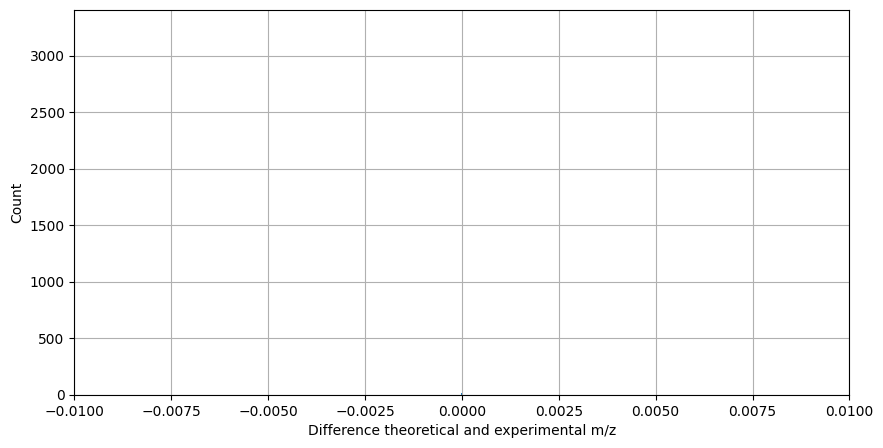

In [63]:
wout_df['difference_experimental_theoretical'].hist(bins=1000, figsize=(10, 5))
plt.xlim(-0.01, 0.01)
plt.xlabel('Difference theoretical and experimental m/z')
plt.ylabel('Count')

plt.show()

In [64]:
subset = [
    ppm
    for ppm in wout_df['ppm']
    if abs(ppm) < 2
]

In [65]:
print('Percent of data with ppm < 2: ', (len(subset) / wout_df.shape[0]) * 100)

Percent of data with ppm < 2:  80.50680413934272


/Users/chloe/Desktop/weighted-mod-cosine-sim/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/42/5d8q8sxj7jl7qbzh9rsv75bw0000gn/T/ipykernel_32495/3951946479.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


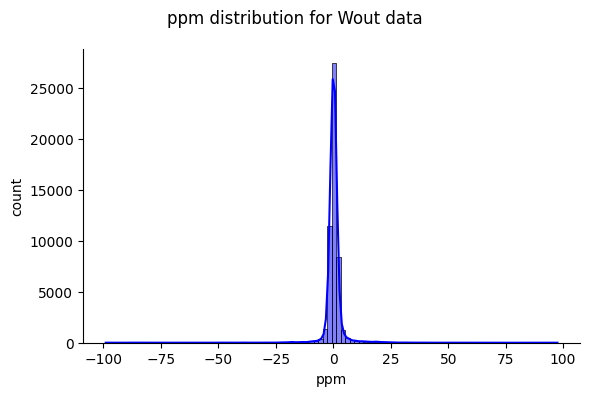

In [66]:
# increase plot size
plt.rcParams['figure.figsize'] = [10, 5]

ax = sns.displot(
    wout_df.ppm,
    # type of plot
    kind='hist',
    bins=100,
    kde=True,
    color='blue',
    alpha=0.5,
    linewidth=0.5,
    height=4,
    aspect=1.5,
)


plt.xlabel('ppm')
plt.ylabel('count')

plt.suptitle('ppm distribution for Wout data')
plt.tight_layout()
plt.show()

In [ ]:
wout_df = wout_df.set_index('spectrumid')
wout_df.to_csv('../../data/wout_ppm.csv')